In [1]:
import os
import kagglehub
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix, roc_curve, auc 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

import joblib

/Users/berkay/Library/Caches/pypoetry/virtualenvs/customer-satisfaction-UJjsLxs7-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

In [2]:
# Download latest version of this project's dataset
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction/version/1")
train = pd.read_csv(os.path.join(path, "train.csv"))
test = pd.read_csv(os.path.join(path, "test.csv"))

print("Path to dataset files:", path)

Path to dataset files: /Users/berkay/.cache/kagglehub/datasets/teejmahal20/airline-passenger-satisfaction/versions/1


In [3]:
train = train.drop(columns=['Unnamed: 0', 'id'])
test = test.drop(columns=['Unnamed: 0', 'id'])

In [4]:
# Represent "satisfaction", a string column, as a numerical value.
label_encoder = LabelEncoder()
train['satisfaction'] = label_encoder.fit_transform(train['satisfaction'])
test['satisfaction'] = label_encoder.transform(test['satisfaction'])

In [5]:
# Apply one-hot encoding
# https://www.geeksforgeeks.org/ml-one-hot-encoding/
categorical = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns=categorical, drop_first=True)
test = pd.get_dummies(test, columns=categorical, drop_first=True)

# Visualization

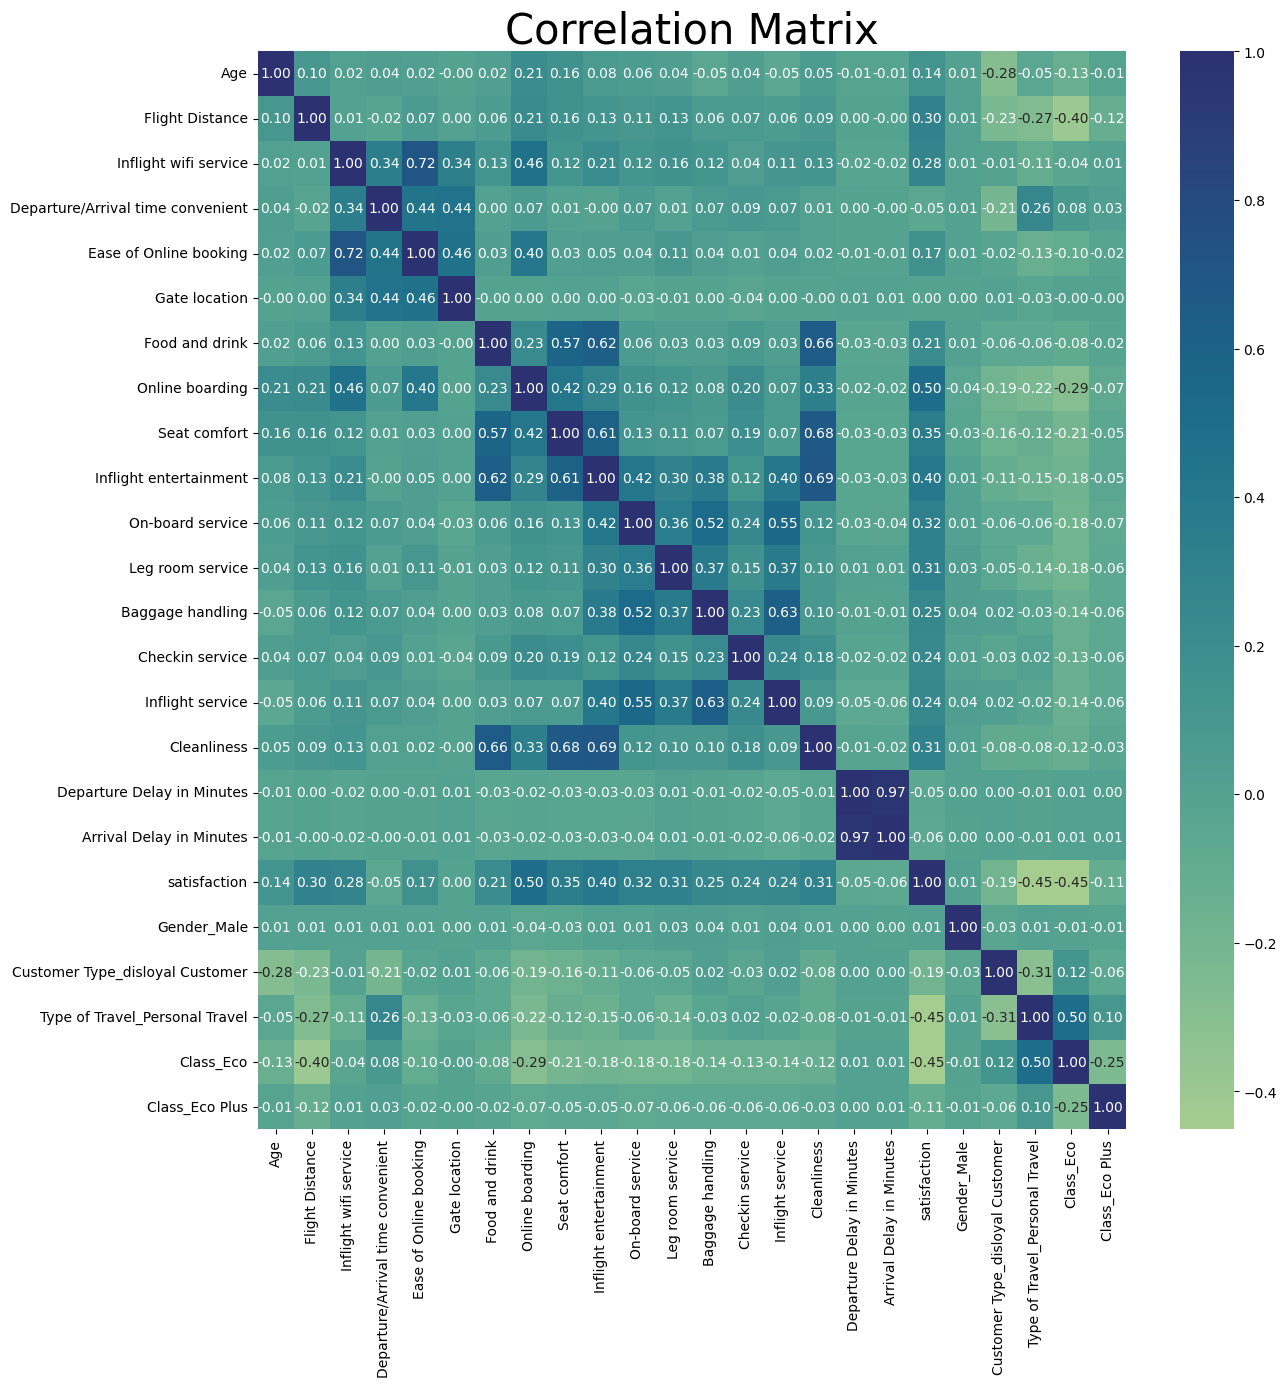

In [6]:
# Display the correlation matrix
def display_correlation_matrix(df):
    plt.figure(figsize=(14, 14))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='crest', cbar=True)
    plt.title('Correlation Matrix', fontsize=30)
    plt.show()

display_correlation_matrix(train)

# Removal of NaN values & separation of outcomes

In [7]:
train.dropna(axis=0,inplace=True)
test.dropna(axis=0,inplace=True)

X_train = train.drop(columns=['satisfaction'])
y_train = train['satisfaction']

X_test = test.drop(columns=['satisfaction'])
y_test = test['satisfaction']

def evaluate_performance(actual, prediction, probability):
    # Calculate performance metrics
    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    auc = roc_auc_score(actual, probability)
    kappa = cohen_kappa_score(actual, prediction)
    
    # Print performance metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Cohen's Kappa: {kappa:.2f}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(actual, prediction)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral/Dissatisfied', 'Satisfied'], yticklabels=['Neutral/Dissatisfied', 'Satisfied'])
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

    # Draw ROC curve
    fpr, tpr, _ = roc_curve(actual, probability)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title('ROC Curve', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

# Model evaluation without normalization

## K-Nearest Neighbors

Accuracy: 0.75
Precision: 0.73
Recall: 0.67
F1-Score: 0.70
AUC: 0.80
Cohen's Kappa: 0.48


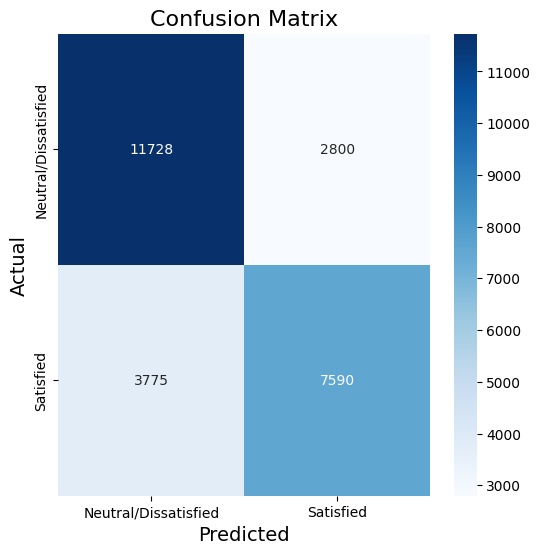

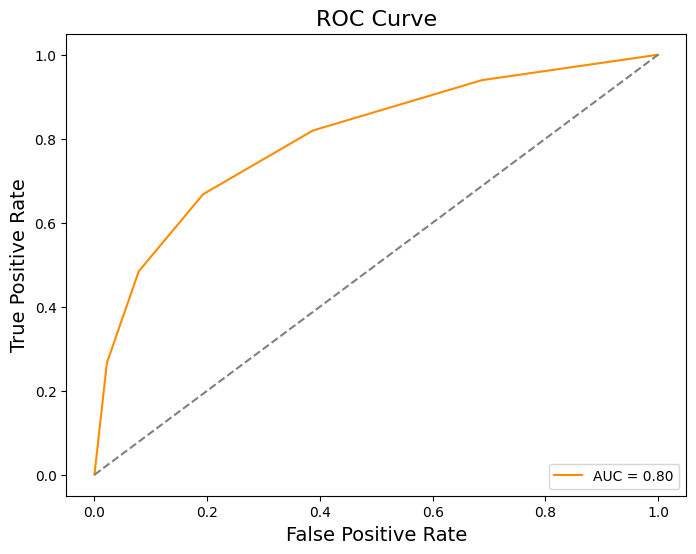

In [8]:
def knn(X_train, y_train, X_test, **kwargs):
    knn_model = KNeighborsClassifier(**kwargs) 
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    y_prob = knn_model.predict_proba(X_test)[:, 1]
    evaluate_performance(y_test, y_pred, y_prob)

knn(X_train, y_train, X_test, n_neighbors=5)

## Logistic Regression

Accuracy: 0.87
Precision: 0.87
Recall: 0.83
F1-Score: 0.85
AUC: 0.93
Cohen's Kappa: 0.74


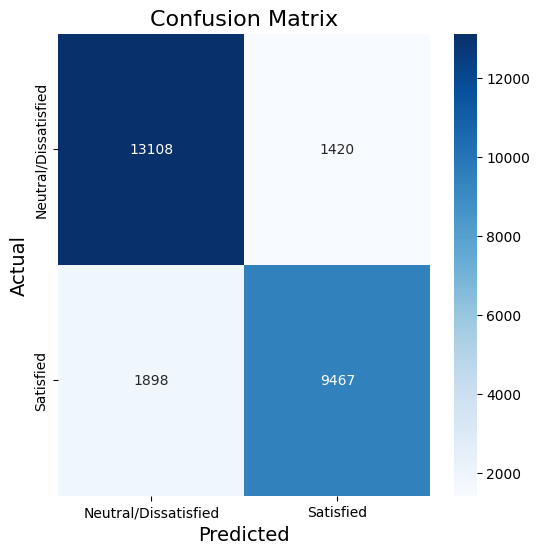

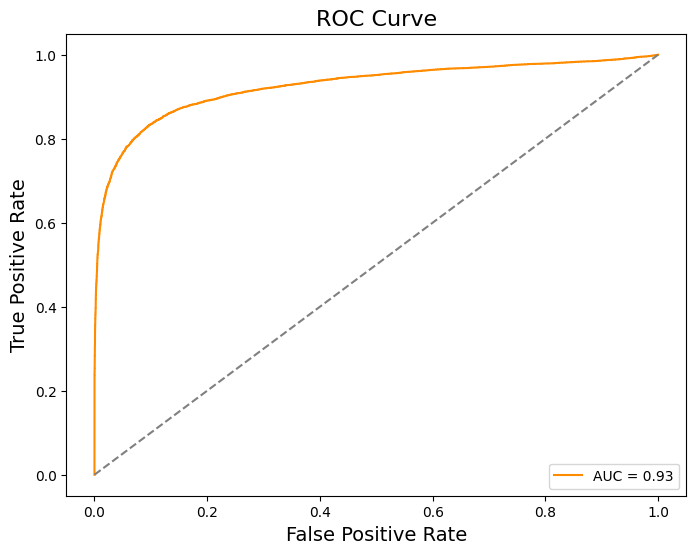

In [9]:
def logistic_regression(X_train, y_train, X_test, **kwargs):
    logistic_model = LogisticRegression(**kwargs)
    logistic_model.fit(X_train, y_train)    
    y_pred = logistic_model.predict(X_test)
    y_prob = logistic_model.predict_proba(X_test)[:, 1]
    evaluate_performance(y_test, y_pred, y_prob)
    
logistic_regression(X_train, y_train, X_test, max_iter=5000, random_state=42)

## Random Forest

Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1-Score: 0.96
AUC: 0.99
Cohen's Kappa: 0.92


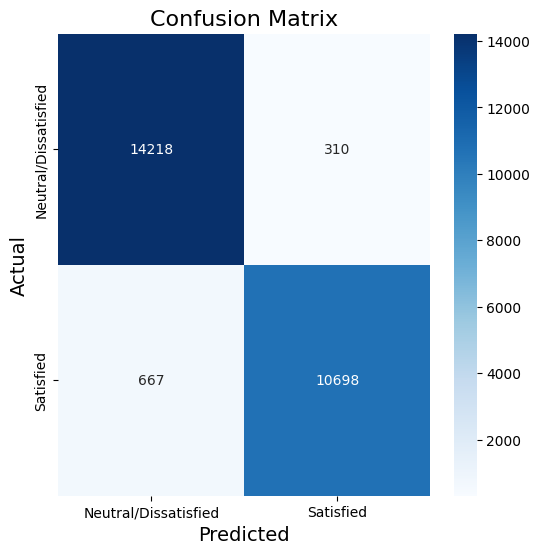

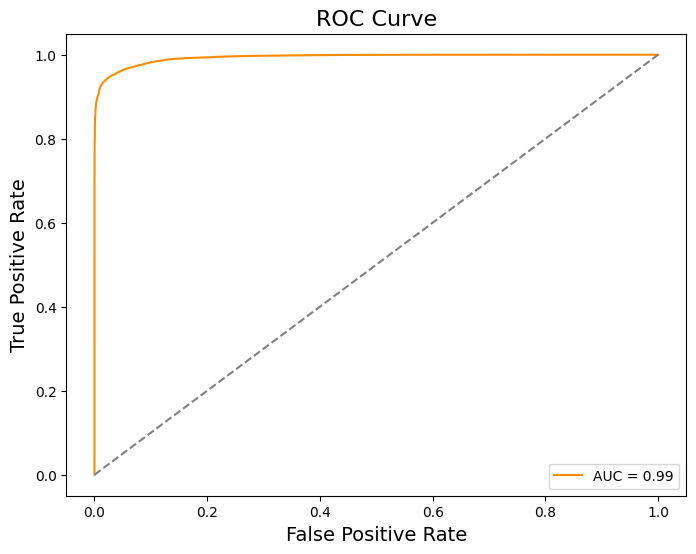

RandomForestClassifier(random_state=42)

In [10]:
def random_forest(X_train, y_train, X_test, **kwargs):
    rf_model = RandomForestClassifier(**kwargs)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    evaluate_performance(y_test, y_pred, y_prob)
    return rf_model

random_forest(X_train, y_train, X_test, n_estimators=100, random_state=42)

# Normalization

In [11]:
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns.to_list()
numeric_columns.remove('satisfaction')

scaler = StandardScaler()
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])
test[numeric_columns] = scaler.transform(test[numeric_columns])

X_train = train.drop(columns=['satisfaction'])
y_train = train['satisfaction']

X_test = test.drop(columns=['satisfaction'])
y_test = test['satisfaction']

# Model evaluation with normalization

## K-Nearest Neighbors

Accuracy: 0.93
Precision: 0.94
Recall: 0.89
F1-Score: 0.92
AUC: 0.97
Cohen's Kappa: 0.85


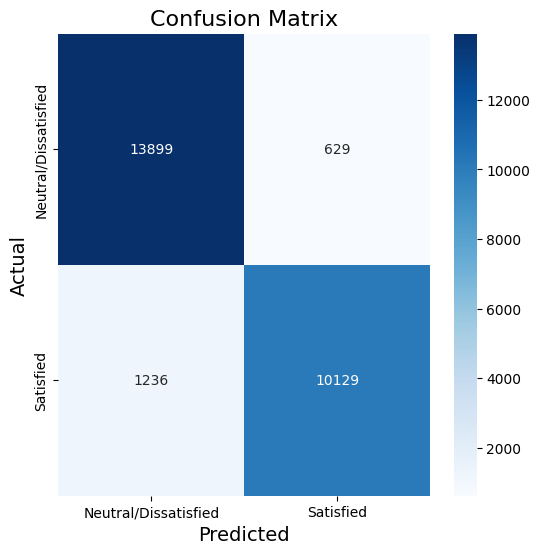

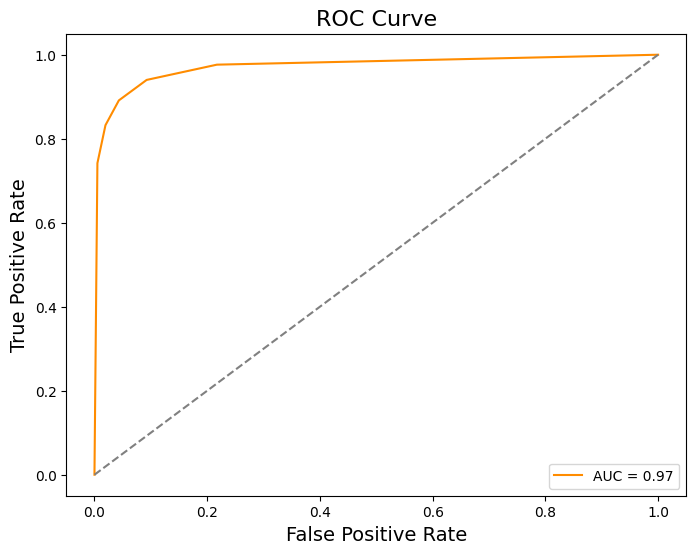

In [12]:
knn(X_train, y_train, X_test, n_neighbors=5)

## Logistic Regression

Accuracy: 0.87
Precision: 0.87
Recall: 0.83
F1-Score: 0.85
AUC: 0.93
Cohen's Kappa: 0.74


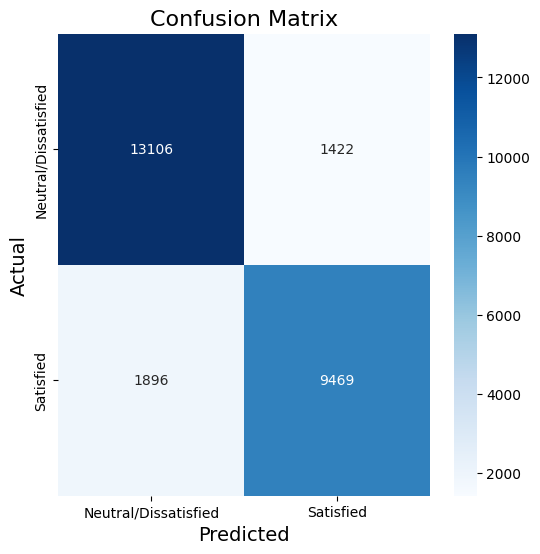

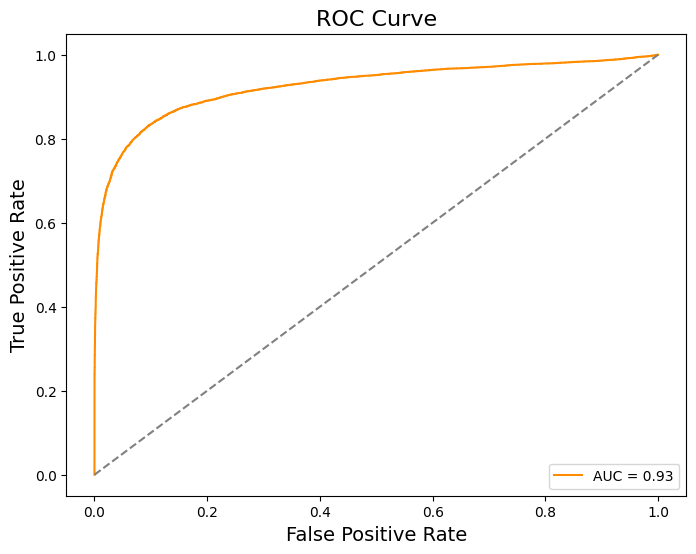

In [13]:
logistic_regression(X_train, y_train, X_test, max_iter=5000, random_state=42)

## Random Forest

Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1-Score: 0.96
AUC: 0.99
Cohen's Kappa: 0.92


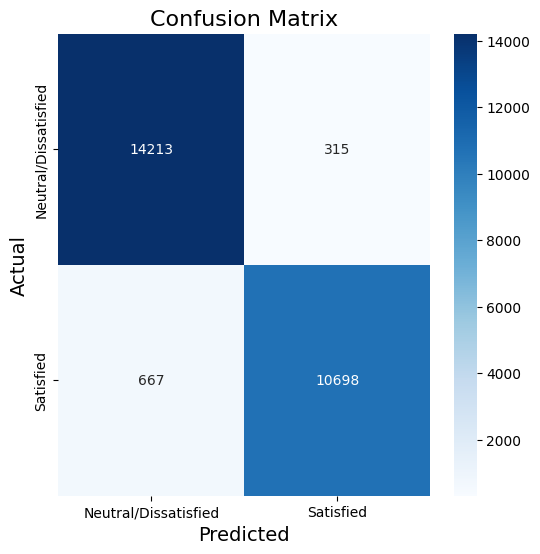

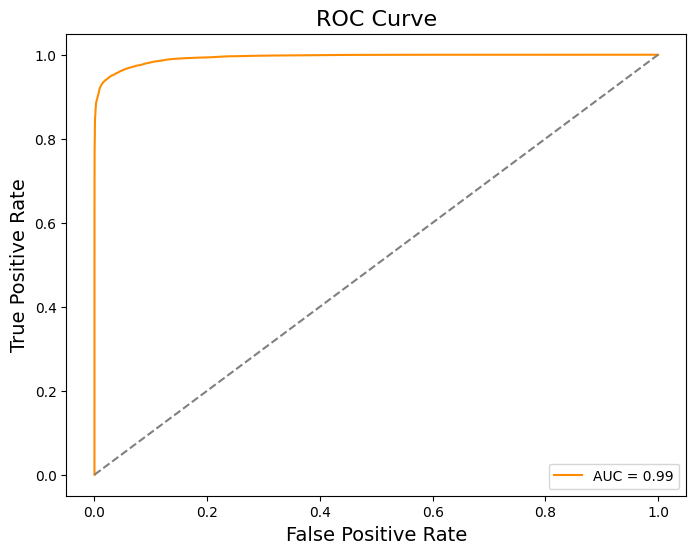

In [28]:
rf = random_forest(X_train, y_train, X_test, n_estimators=100, random_state=42)

In [15]:
mutual_info_scores_raw = mutual_info_classif(X_train, y_train, random_state=42)

mutual_info_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': mutual_info_scores_raw
}).sort_values(by='Score', ascending=False)

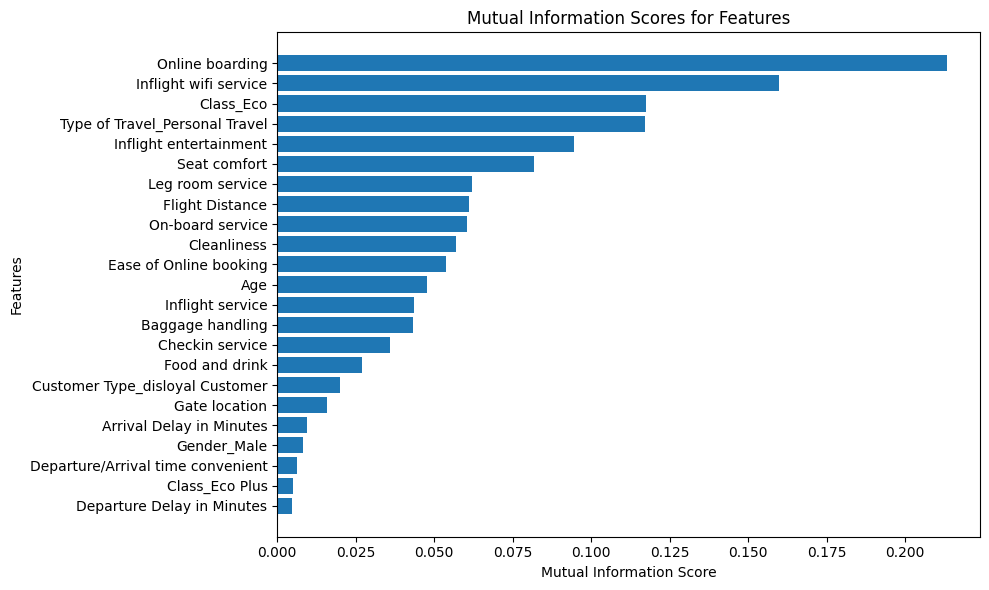

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(mutual_info_scores['Feature'], mutual_info_scores['Score'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores for Features')
plt.tight_layout()
plt.show()

# Model evaluation after normalization & feature selection  

In [17]:
n_top_features = 10
top_features = mutual_info_scores.head(n_top_features)['Feature'].to_numpy()
print(f"List of top {n_top_features} important features: {top_features}")


List of top 10 important features: ['Online boarding' 'Inflight wifi service' 'Class_Eco'
 'Type of Travel_Personal Travel' 'Inflight entertainment' 'Seat comfort'
 'Leg room service' 'Flight Distance' 'On-board service' 'Cleanliness']


In [18]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

## K-Nearest Neighbors

Accuracy: 0.93
Precision: 0.94
Recall: 0.90
F1-Score: 0.92
AUC: 0.97
Cohen's Kappa: 0.86


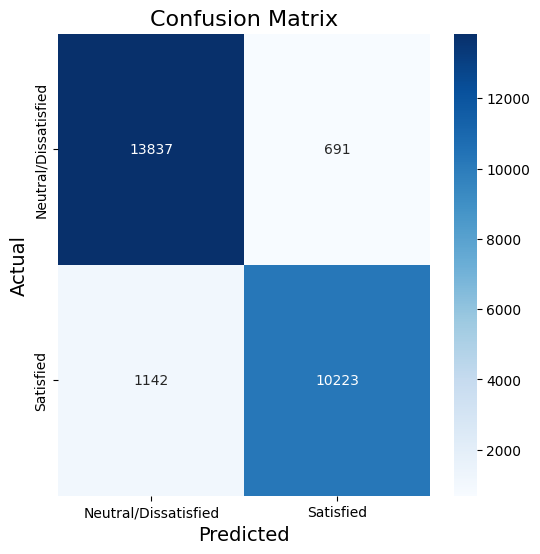

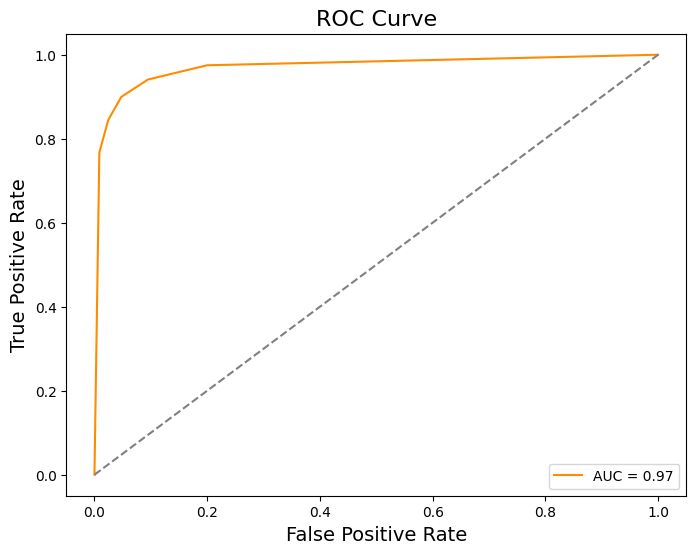

In [19]:
knn(X_train_selected, y_train, X_test_selected, n_neighbors=5)

## Logistic Regression

Accuracy: 0.85
Precision: 0.84
Recall: 0.82
F1-Score: 0.83
AUC: 0.91
Cohen's Kappa: 0.70


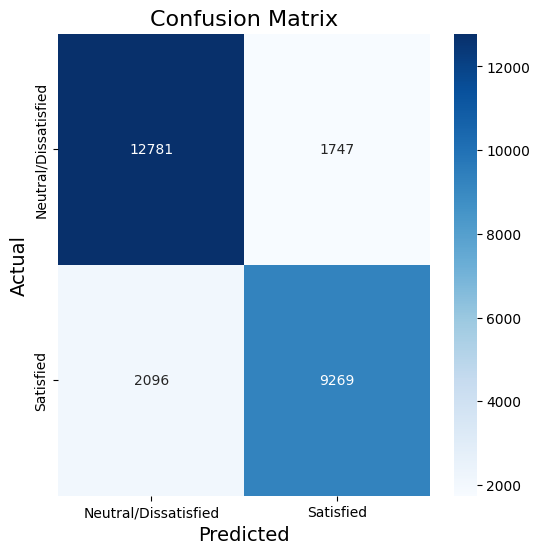

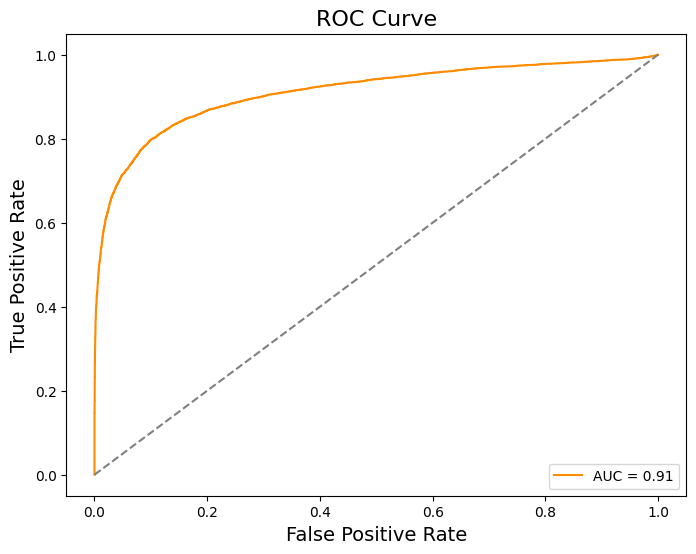

In [20]:
logistic_regression(X_train_selected, y_train, X_test_selected, max_iter=5000, random_state=42)

## Random Forest

Accuracy: 0.93
Precision: 0.93
Recall: 0.91
F1-Score: 0.92
AUC: 0.98
Cohen's Kappa: 0.86


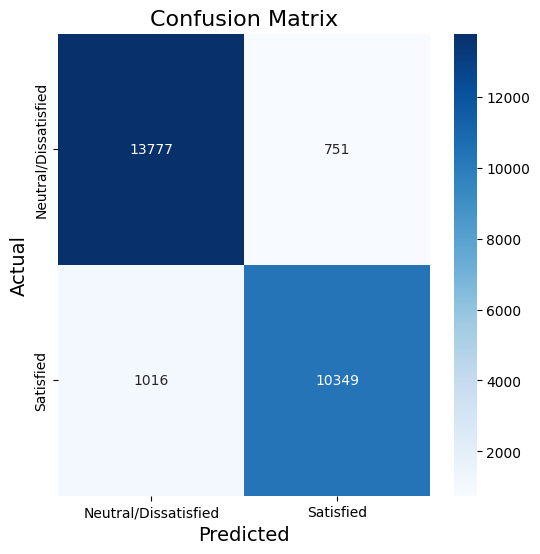

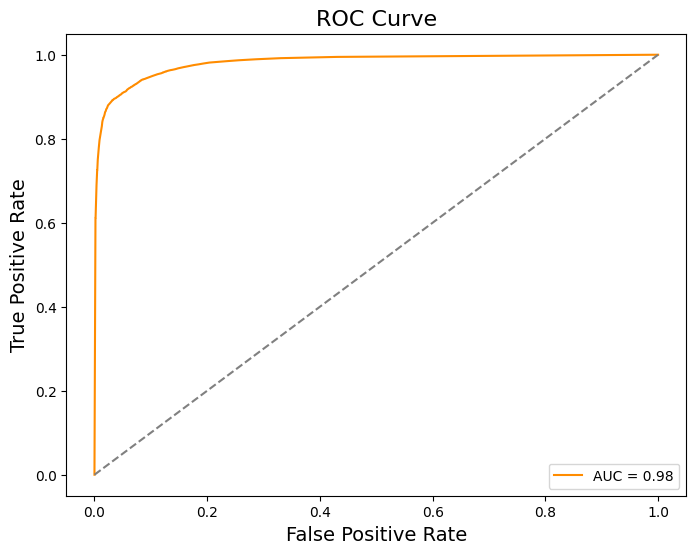

In [21]:
random_forest(X_train_selected, y_train, X_test_selected, n_estimators=100, random_state=42)

In [29]:
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(rf, 'rf.joblib')
joblib.dump(label_encoder, 'le.joblib')

['le.joblib']

In [30]:
display(X_train.columns)

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus'],
      dtype='object')